In [48]:
import sys
sys.path.insert(0, '..')

In [49]:
import controllers as c
import numpy as np
import pandas as pd

In [50]:
reports = c.get_reports(limit=900)

masters = [r for r in reports if r.dupe_of is None]

all_duplicates = [r for r in reports if r.dupe_of is not None]
duplicates = []
for d in all_duplicates:
    master = [m for m in masters if m.report_id == d.dupe_of]
    if len(master) > 0:
        duplicates.append(d) 

reports = masters + duplicates

columns = [c for c in list(reports[0].__dict__.keys()) if c != '_id']
df_reports = pd.DataFrame(columns=columns, data=[r.__dict__ for r in reports])

In [51]:
df_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   report_id      892 non-null    int64         
 1   creation_time  892 non-null    datetime64[ns]
 2   status         892 non-null    object        
 3   component      892 non-null    object        
 4   dupe_of        321 non-null    float64       
 5   summary        892 non-null    object        
 6   comments       892 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 48.9+ KB


# Creación de pares de reportes

In [52]:
from random import choice

N_MASTER_PAIRS = 400
N_DUPLICATE_PAIRS = 100

## Generación maestro-maestro

In [53]:
master_pairs = []

while len(master_pairs) < N_MASTER_PAIRS:
    pair = choice(masters), choice(masters)
    if all([
        pair[0].report_id != pair[1].report_id,
        pair not in master_pairs
    ]):
        master_pairs.append(pair)

In [54]:
m_sample_pair = choice(master_pairs)
print("Par maestro-maestro de ejemplo: \n")
print(str(m_sample_pair[0]))
print(str(m_sample_pair[1]))
print()
print(f"Número de pares de maestro-maestro: {len(master_pairs)}")

Par maestro-maestro de ejemplo: 

Report 1427973 (dupe of None) - Should track the origins of `openPreferences` from mozscreenshots and urlbarBindings.xml
Report 1197583 (dupe of None) - "F.B. Purity - Cleans Up Facebook" add-on does not work with e10s

Número de pares de maestro-maestro: 400


## Generación maestro-duplicado

In [55]:
duplicate_pairs = []

for d_report in duplicates:
    master = [m for m in masters if m.report_id == d_report.dupe_of][0]
    pair = master, d_report
    duplicate_pairs.append(pair)
    
    if len(duplicate_pairs) == N_DUPLICATE_PAIRS:
        break

In [56]:
d_sample_pair = choice(duplicate_pairs)
print("Par maestro-duplicado de ejemplo: \n")
print(str(d_sample_pair[0]))
print(str(d_sample_pair[1]))
print()
print(f"Número de pares de maestro-duplicado: {len(duplicate_pairs)}")

Par maestro-duplicado de ejemplo: 

Report 1498974 (dupe of None) - Addon enabled state not managed correctly
Report 1685289 (dupe of 1498974) - The status of extensions (enabled/disabled) is not synced between devices

Número de pares de maestro-duplicado: 100


In [57]:
PAIR_COLUMNS = [
    'type', 
    'id_M', 'id_D', 'statusM', 'statusD', 'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM', 'commentsD'
]

df_duplicate_pairs = pd.DataFrame(columns=PAIR_COLUMNS)
df_master_pairs = pd.DataFrame(columns=PAIR_COLUMNS)

for pair in duplicate_pairs:
    df_pair = pd.DataFrame(columns=PAIR_COLUMNS, data=[{
        'type': 'duplicate',
        'id_M': pair[0].report_id,
        'id_D': pair[1].report_id,
        'statusM': pair[0].status,
        'statusD': pair[1].status,
        'componentM': pair[0].component,
        'componentD': pair[1].component,
        'summaryM': pair[0].summary,
        'summaryD': pair[1].summary,
        'commentsM': pair[0].comments,
        'commentsD': pair[1].comments
    }])
    df_duplicate_pairs = pd.concat([df_duplicate_pairs, df_pair])

for pair in master_pairs:
    df_pair = pd.DataFrame(columns=PAIR_COLUMNS, data=[{
        'type': 'master',
        'id_M': pair[0].report_id,
        'id_D': pair[1].report_id,
        'statusM': pair[0].status,
        'statusD': pair[1].status,
        'componentM': pair[0].component,
        'componentD': pair[1].component,
        'summaryM': pair[0].summary,
        'summaryD': pair[1].summary,
        'commentsM': pair[0].comments,
        'commentsD': pair[1].comments
    }])
    df_master_pairs = pd.concat([df_master_pairs, df_pair])

df_report_pairs = pd.concat([df_duplicate_pairs, df_master_pairs])

df_report_pairs.reset_index(drop=True, inplace=True)
df_duplicate_pairs.reset_index(drop=True, inplace=True)
df_master_pairs.reset_index(drop=True, inplace=True)


In [58]:
df_report_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,commentsD
23,duplicate,1643789,1685929,RESOLVED,RESOLVED,DOM: Navigation,Address Bar,Shouldn't use alternate fixup for links placed...,URL Link Exploit,1. Browse https://4programmers.net/Forum/Spol...,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...
64,duplicate,1611472,1608697,VERIFIED,RESOLVED,Networking,Session Restore,72.0+ not handling 403 response from proxy pro...,Session restore during startup loses pages' UR...,User Agent: Mozilla/5.0 (X11; Linux x86_64; rv...,User Agent: Mozilla/5.0 (Windows NT 6.1; Win64...
439,master,1214082,1491046,RESOLVED,RESOLVED,Address Bar,Enterprise Policies,URL bar highlighting for EV certs truncates lo...,Add support for arbitrary preferences in policies,Firefox is truncating the EV org name highligh...,There are simply too many preferences to try t...


# Dúsqueda de patrones entre pares maestro-duplicado

## Campos 'status' y 'component'

In [59]:
# Get the number of rows with statusM = statusD
same_status_pairs = df_duplicate_pairs[(df_duplicate_pairs.statusM == df_duplicate_pairs.statusD)]
same_component_pairs = df_duplicate_pairs[(df_duplicate_pairs.componentM == df_duplicate_pairs.componentD)]
print(f"Número de pares de duplicados con mismo estado: {len(same_status_pairs)} ({len(same_status_pairs) / len(df_duplicate_pairs) * 100:.2f}% de los duplicados)")
print(f"Número de pares de duplicados con mismo componente: {len(same_component_pairs)} ({len(same_component_pairs) / len(df_duplicate_pairs) * 100:.2f}% de los duplicados)")

status_counts = {}
for status in df_duplicate_pairs.statusM.unique():
    status_counts[status] = len(df_duplicate_pairs[(df_duplicate_pairs.statusM == status) & (df_duplicate_pairs.statusD == status)])
status_counts = sorted(status_counts.items(), key=lambda x: x[1], reverse=True)
status_counts = [x for x in status_counts if x[1] > 0]

component_counts = {}
for component in df_duplicate_pairs.componentM.unique():
    component_counts[component] = len(df_duplicate_pairs[(df_duplicate_pairs.componentM == component) & (df_duplicate_pairs.componentD == component)])
component_counts = sorted(component_counts.items(), key=lambda x: x[1], reverse=True)
component_counts = [x for x in component_counts if x[1] > 0]

Número de pares de duplicados con mismo estado: 35 (35.00% de los duplicados)
Número de pares de duplicados con mismo componente: 50 (50.00% de los duplicados)


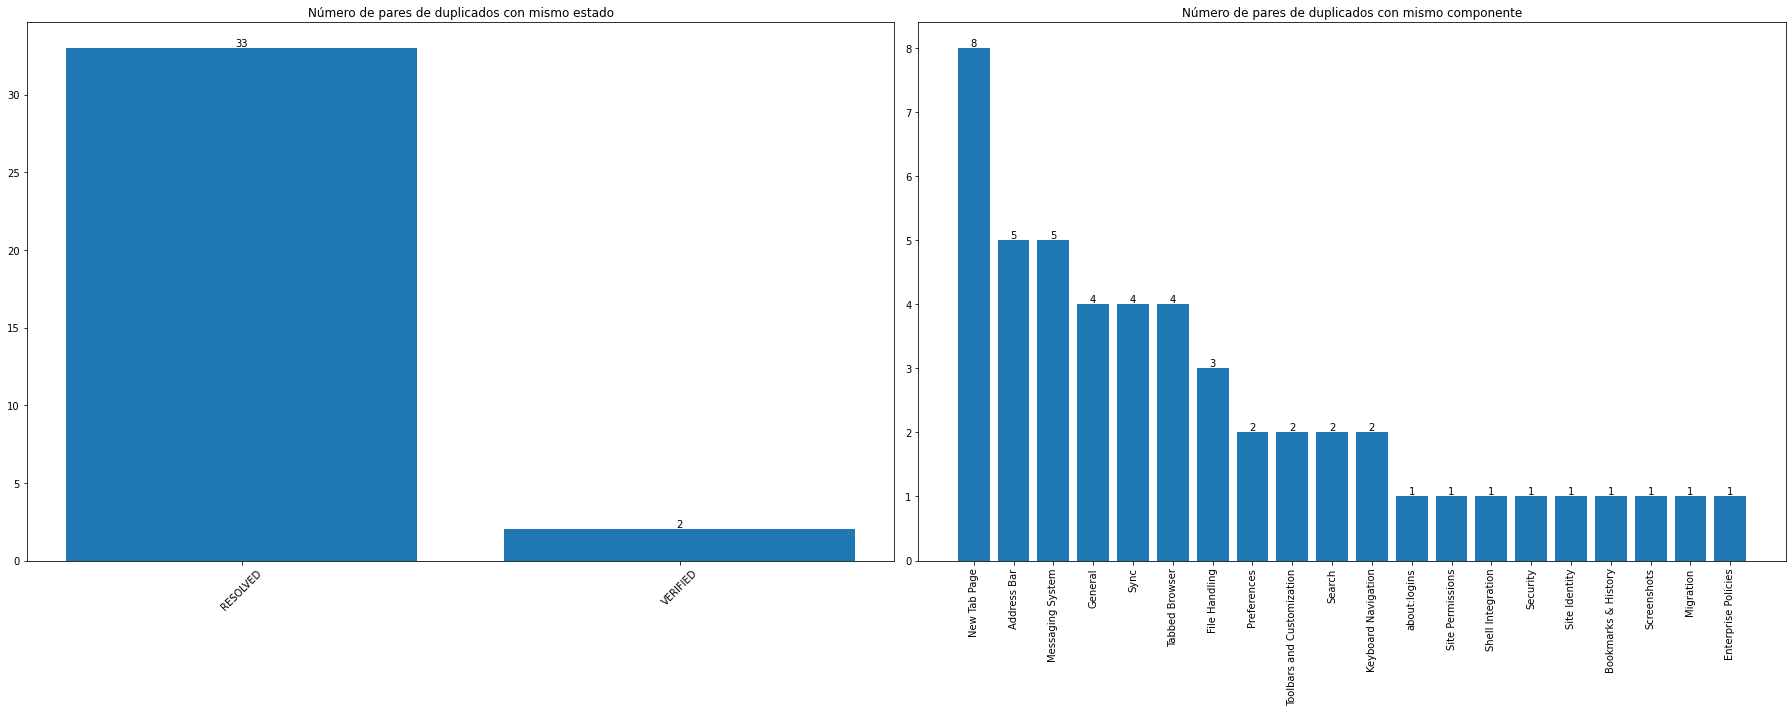

In [60]:
import matplotlib.pyplot as plt

# subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

# plot status counts
axs[0].bar(range(len(status_counts)), [count for status, count in status_counts], align='center')
axs[0].set_xticks(range(len(status_counts)))
axs[0].set_xticklabels([status for status, count in status_counts], rotation=45)
axs[0].set_title('Número de pares de duplicados con mismo estado')
for i, (status, count) in enumerate(status_counts):
    axs[0].text(i, count, count, ha='center', va='bottom')

# plot component counts
axs[1].bar(range(len(component_counts)), [count for component, count in component_counts], align='center')
axs[1].set_xticks(range(len(component_counts)))
axs[1].set_xticklabels([component for component, count in component_counts], rotation=90)
axs[1].set_title('Número de pares de duplicados con mismo componente')
for i, (component, count) in enumerate(component_counts):
    axs[1].text(i, count, count, ha='center', va='bottom')

fig.tight_layout()
plt.show()

## Campos 'summary' y 'comments'

### Creación de varios conjuntos

In [61]:
for i, row in df_reports.iterrows():
    # Conjunto 1: text = summary
    df_reports.at[i, 'text1'] = row.summary
    # Conjunto 2: text = summary + component
    df_reports.at[i, 'text2'] = row.summary + ' ' + row.component
    # Conjunto 3: text = summary + comments (si len(comments) < 1000)
    df_reports.at[i, 'text3'] = row.summary if len(row.comments) > 1000 else row.summary + ' ' + row.comments
    # Conjunto 4: text = summary + component + comments (si len(comments) < 250)
    if len(row.comments) > 250:
        df_reports.at[i, 'text4'] = row.summary + ' ' + row.component
    else:
        df_reports.at[i, 'text4'] = row.summary + ' ' + row.component + ' ' + row.comments


In [62]:
for i, row in df_report_pairs.iterrows():
    # Conjunto 1: text = summary
    df_report_pairs.at[i, 'text1M'] = row.summaryM
    df_report_pairs.at[i, 'text1D'] = row.summaryD
    # Conjunto 2: text = summary + component
    df_report_pairs.at[i, 'text2M'] = row.summaryM + ' ' + row.componentM
    df_report_pairs.at[i, 'text2D'] = row.summaryD + ' ' + row.componentD
    # Conjunto 3: text = summary + comments (si len(comments) < 1000)
    df_report_pairs.at[i, 'text3M'] = row.summaryM if len(row.commentsM) > 1000 else row.summaryM + ' ' + row.commentsM
    df_report_pairs.at[i, 'text3D'] = row.summaryD if len(row.commentsD) > 1000 else row.summaryD + ' ' + row.commentsD
    # Conjunto 4: text = summary + component + comments (si len(comments) < 250)
    if len(row.commentsM) > 250:
        df_report_pairs.at[i, 'text4M'] = row.summaryM + ' ' + row.componentM
    else:
        df_report_pairs.at[i, 'text4M'] = row.summaryM + ' ' + row.componentM + ' ' + row.commentsM
    if len(row.commentsD) > 250:
        df_report_pairs.at[i, 'text4D'] = row.summaryD + ' ' + row.componentD
    else:
        df_report_pairs.at[i, 'text4D'] = row.summaryD + ' ' + row.componentD + ' ' + row.commentsD


### Longitudes y diferencias de longitudes

In [63]:
df_report_pairs['summaryM_len'] = df_report_pairs.summaryM.apply(len)
df_report_pairs['summaryD_len'] = df_report_pairs.summaryD.apply(len)
df_report_pairs['summary_len_diff'] = df_report_pairs.summaryM_len - df_report_pairs.summaryD_len

df_report_pairs['commentsM_len'] = df_report_pairs.commentsM.apply(len)
df_report_pairs['commentsD_len'] = df_report_pairs.commentsD.apply(len)
df_report_pairs['comments_len_diff'] = df_report_pairs.commentsM_len - df_report_pairs.commentsD_len

df_report_pairs['text1M_len1'] = df_report_pairs.text1M.apply(len)
df_report_pairs['text1D_len'] = df_report_pairs.text1D.apply(len)
df_report_pairs['text1_len_diff'] = df_report_pairs.text1M_len1 - df_report_pairs.text1D_len

df_report_pairs['text2M_len'] = df_report_pairs.text2M.apply(len)
df_report_pairs['text2D_len'] = df_report_pairs.text2D.apply(len)
df_report_pairs['text2_len_diff'] = df_report_pairs.text2M_len - df_report_pairs.text2D_len

df_report_pairs['text3M_len'] = df_report_pairs.text3M.apply(len)
df_report_pairs['text3D_len'] = df_report_pairs.text3D.apply(len)
df_report_pairs['text3_len_diff'] = df_report_pairs.text3M_len - df_report_pairs.text3D_len

df_report_pairs['text4M_len'] = df_report_pairs.text4M.apply(len)
df_report_pairs['text4D_len'] = df_report_pairs.text4D.apply(len)
df_report_pairs['text4_len_diff'] = df_report_pairs.text4M_len - df_report_pairs.text4D_len

In [64]:
df_duplicate_pairs = df_report_pairs[df_report_pairs.type == 'duplicate']
df_master_pairs = df_report_pairs[df_report_pairs.type == 'master']

df_duplicate_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,...,text1_len_diff,text2M_len,text2D_len,text2_len_diff,text3M_len,text3D_len,text3_len_diff,text4M_len,text4D_len,text4_len_diff
85,duplicate,1601905,1608070,VERIFIED,RESOLVED,XPCOM,File Handling,68.3.x can't open attachments with spaces in name,Unable to open document with space in filename...,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,-18,55,81,-26,49,713,-664,55,81,-26
51,duplicate,1651304,1642982,NEW,RESOLVED,Address Bar,Address Bar,Firefox doesn't load first opened website,Intermittently hitting enter on a URL fails to...,"Firefox 79.0b5 (64-bit), Ubuntu 18.04.\n\nSTR:...",...,-14,53,67,-14,360,825,-465,53,67,-14
31,duplicate,1685251,1685404,VERIFIED,RESOLVED,New Tab Page,New Tab Page,Top Sites icons are not editable without newNe...,"Cannot unpin top site, menu not visible",User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,21,73,52,21,578,377,201,73,52,21


In [65]:
df_duplicate_pairs[[
       'summaryM_len', 'summaryD_len', 'summary_len_diff',
       'commentsM_len', 'commentsD_len', 'comments_len_diff'
]].describe()

,summaryM_len,summaryD_len,summary_len_diff,commentsM_len,commentsD_len,comments_len_diff
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,82.890000,70.420000,12.470000,1750.340000,1729.340000,21.000000
std,56.230747,47.657486,52.694556,4893.829927,4333.523332,5641.829018
min,19.000000,16.000000,-151.000000,0.000000,0.000000,-23843.000000
25%,49.000000,44.750000,-8.750000,280.250000,324.250000,-317.750000
50%,63.500000,56.000000,10.500000,602.000000,569.000000,50.500000
75%,98.250000,78.000000,34.250000,990.250000,827.250000,346.000000
max,255.000000,255.000000,223.000000,29980.000000,23843.000000,26908.000000


In [66]:
df_duplicate_pairs[[
    'text1M_len1', 'text1D_len', 'text2M_len', 'text2D_len', 
    'text3M_len', 'text3D_len',  'text4M_len', 'text4D_len', 
    'text1_len_diff', 'text2_len_diff', 'text3_len_diff', 'text4_len_diff'
]].describe()

,text1M_len1,text1D_len,text2M_len,text2D_len,text3M_len,text3D_len,text4M_len,text4D_len,text1_len_diff,text2_len_diff,text3_len_diff,text4_len_diff
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,82.890000,70.420000,95.28000,83.100000,427.780000,480.770000,130.030000,101.910000,12.470000,12.180000,-52.990000,28.120000
std,56.230747,47.657486,56.74933,48.271224,310.313546,295.173767,79.218717,64.161113,52.694556,52.792213,427.880553,93.858294
min,19.000000,16.000000,24.00000,28.000000,23.000000,40.000000,24.000000,28.000000,-151.000000,-152.000000,-960.000000,-230.000000
25%,49.000000,44.750000,57.75000,57.000000,184.000000,207.250000,72.000000,60.500000,-8.750000,-7.250000,-325.750000,-14.500000
50%,63.500000,56.000000,80.00000,70.000000,326.000000,425.500000,99.000000,80.500000,10.500000,10.000000,-3.000000,20.000000
75%,98.250000,78.000000,113.25000,91.250000,647.000000,740.250000,199.000000,120.000000,34.250000,32.750000,203.750000,70.250000
max,255.000000,255.000000,272.00000,270.000000,1070.000000,1086.000000,346.000000,307.000000,223.000000,223.000000,924.000000,275.000000


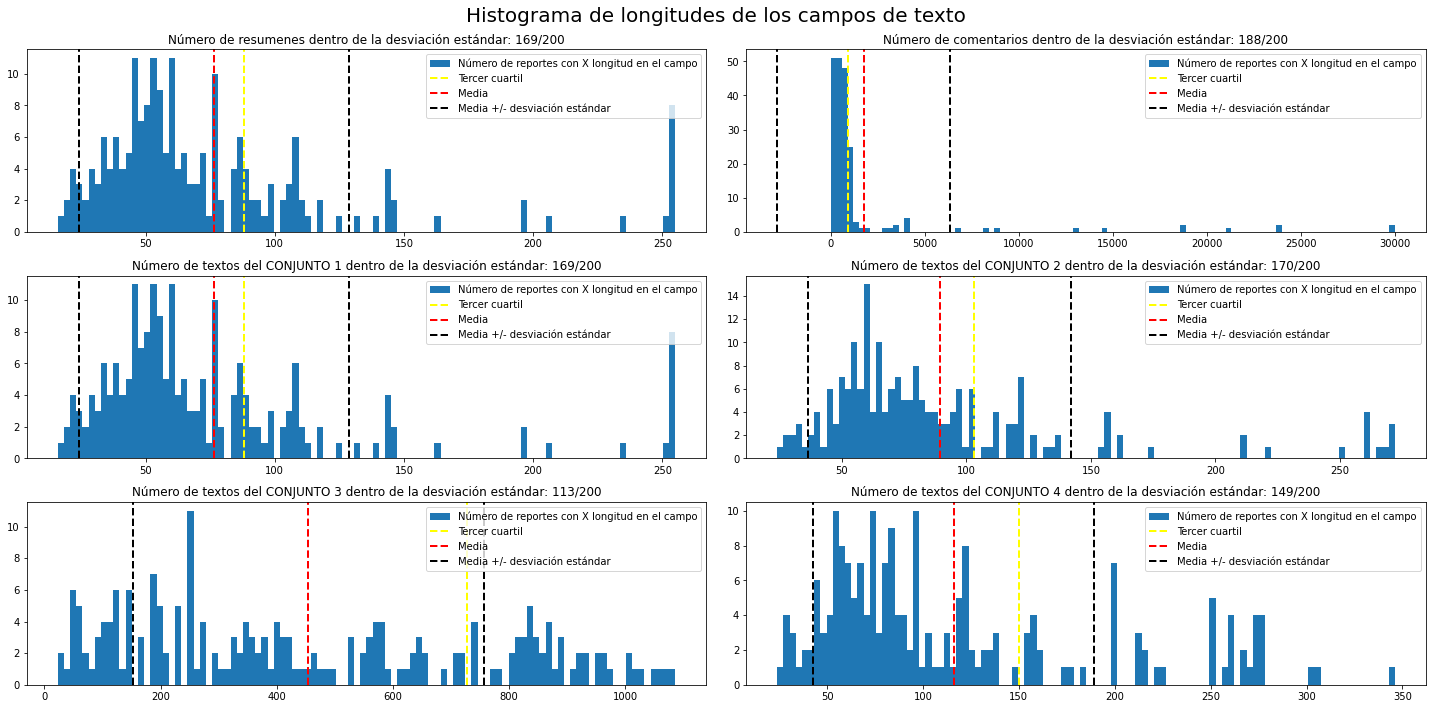

In [67]:
summaries = df_duplicate_pairs[['summaryM_len', 'summaryD_len']].values.flatten()
comments = df_duplicate_pairs[['commentsM_len', 'commentsD_len']].values.flatten()
text1 = df_duplicate_pairs[['text1M_len1', 'text1D_len']].values.flatten()
text2 = df_duplicate_pairs[['text2M_len', 'text2D_len']].values.flatten()
text3 = df_duplicate_pairs[['text3M_len', 'text3D_len']].values.flatten()
text4 = df_duplicate_pairs[['text4M_len', 'text4D_len']].values.flatten()

fig, axs = plt.subplots(3, 2, figsize=(20, 10))

fig.suptitle('Histograma de longitudes de los campos de texto', fontsize=20)

summary_lens_inside_std_count = len(summaries[(summaries > summaries.mean() - summaries.std()) & (summaries < summaries.mean() + summaries.std())])
axs[0,0].hist(summaries, bins=100 , label='Número de reportes con X longitud en el campo')
axs[0,0].axvline(x=np.percentile(summaries,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,0].axvline(x=summaries.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,0].axvline(x=summaries.mean() - summaries.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[0,0].axvline(x=summaries.mean() + summaries.std(), color='black', linestyle='dashed', linewidth=2)
axs[0,0].set_title(f'Número de resumenes dentro de la desviación estándar: {summary_lens_inside_std_count}/{len(summaries)}')
axs[0,0].legend()

comment_lens_inside_std_count = len(comments[(comments > comments.mean() - comments.std()) & (comments < comments.mean() + comments.std())])
axs[0,1].hist(comments, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[0,1].axvline(x=np.percentile(comments,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,1].axvline(x=comments.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,1].axvline(x=comments.mean() - comments.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[0,1].axvline(x=comments.mean() + comments.std(), color='black', linestyle='dashed', linewidth=2)
axs[0,1].set_title(f'Número de comentarios dentro de la desviación estándar: {comment_lens_inside_std_count}/{len(comments)}')
axs[0,1].legend()

text1_lens_inside_std_count = len(text1[(text1 > text1.mean() - text1.std()) & (text1 < text1.mean() + text1.std())])
axs[1,0].hist(text1, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[1,0].axvline(x=np.percentile(text1,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,0].axvline(x=text1.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,0].axvline(x=text1.mean() - text1.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[1,0].axvline(x=text1.mean() + text1.std(), color='black', linestyle='dashed', linewidth=2)
axs[1,0].set_title(f'Número de textos del CONJUNTO 1 dentro de la desviación estándar: {text1_lens_inside_std_count}/{len(text1)}')
axs[1,0].legend()

text2_lens_inside_std_count = len(text2[(text2 > text2.mean() - text2.std()) & (text2 < text2.mean() + text2.std())])
axs[1,1].hist(text2, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[1,1].axvline(x=np.percentile(text2,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,1].axvline(x=text2.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,1].axvline(x=text2.mean() - text2.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[1,1].axvline(x=text2.mean() + text2.std(), color='black', linestyle='dashed', linewidth=2)
axs[1,1].set_title(f'Número de textos del CONJUNTO 2 dentro de la desviación estándar: {text2_lens_inside_std_count}/{len(text2)}')
axs[1,1].legend()

text3_lens_inside_std_count = len(text3[(text3 > text3.mean() - text3.std()) & (text3 < text3.mean() + text3.std())])
axs[2,0].hist(text3, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[2,0].axvline(x=np.percentile(text3,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,0].axvline(x=text3.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,0].axvline(x=text3.mean() - text3.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[2,0].axvline(x=text3.mean() + text3.std(), color='black', linestyle='dashed', linewidth=2)
axs[2,0].set_title(f'Número de textos del CONJUNTO 3 dentro de la desviación estándar: {text3_lens_inside_std_count}/{len(text3)}')
axs[2,0].legend()

text4_lens_inside_std_count = len(text4[(text4 > text4.mean() - text4.std()) & (text4 < text4.mean() + text4.std())])
axs[2,1].hist(text4, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[2,1].axvline(x=np.percentile(text4,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,1].axvline(x=text4.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,1].axvline(x=text4.mean() - text4.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[2,1].axvline(x=text4.mean() + text4.std(), color='black', linestyle='dashed', linewidth=2)
axs[2,1].set_title(f'Número de textos del CONJUNTO 4 dentro de la desviación estándar: {text4_lens_inside_std_count}/{len(text4)}')
axs[2,1].legend()

fig.tight_layout()
plt.show()

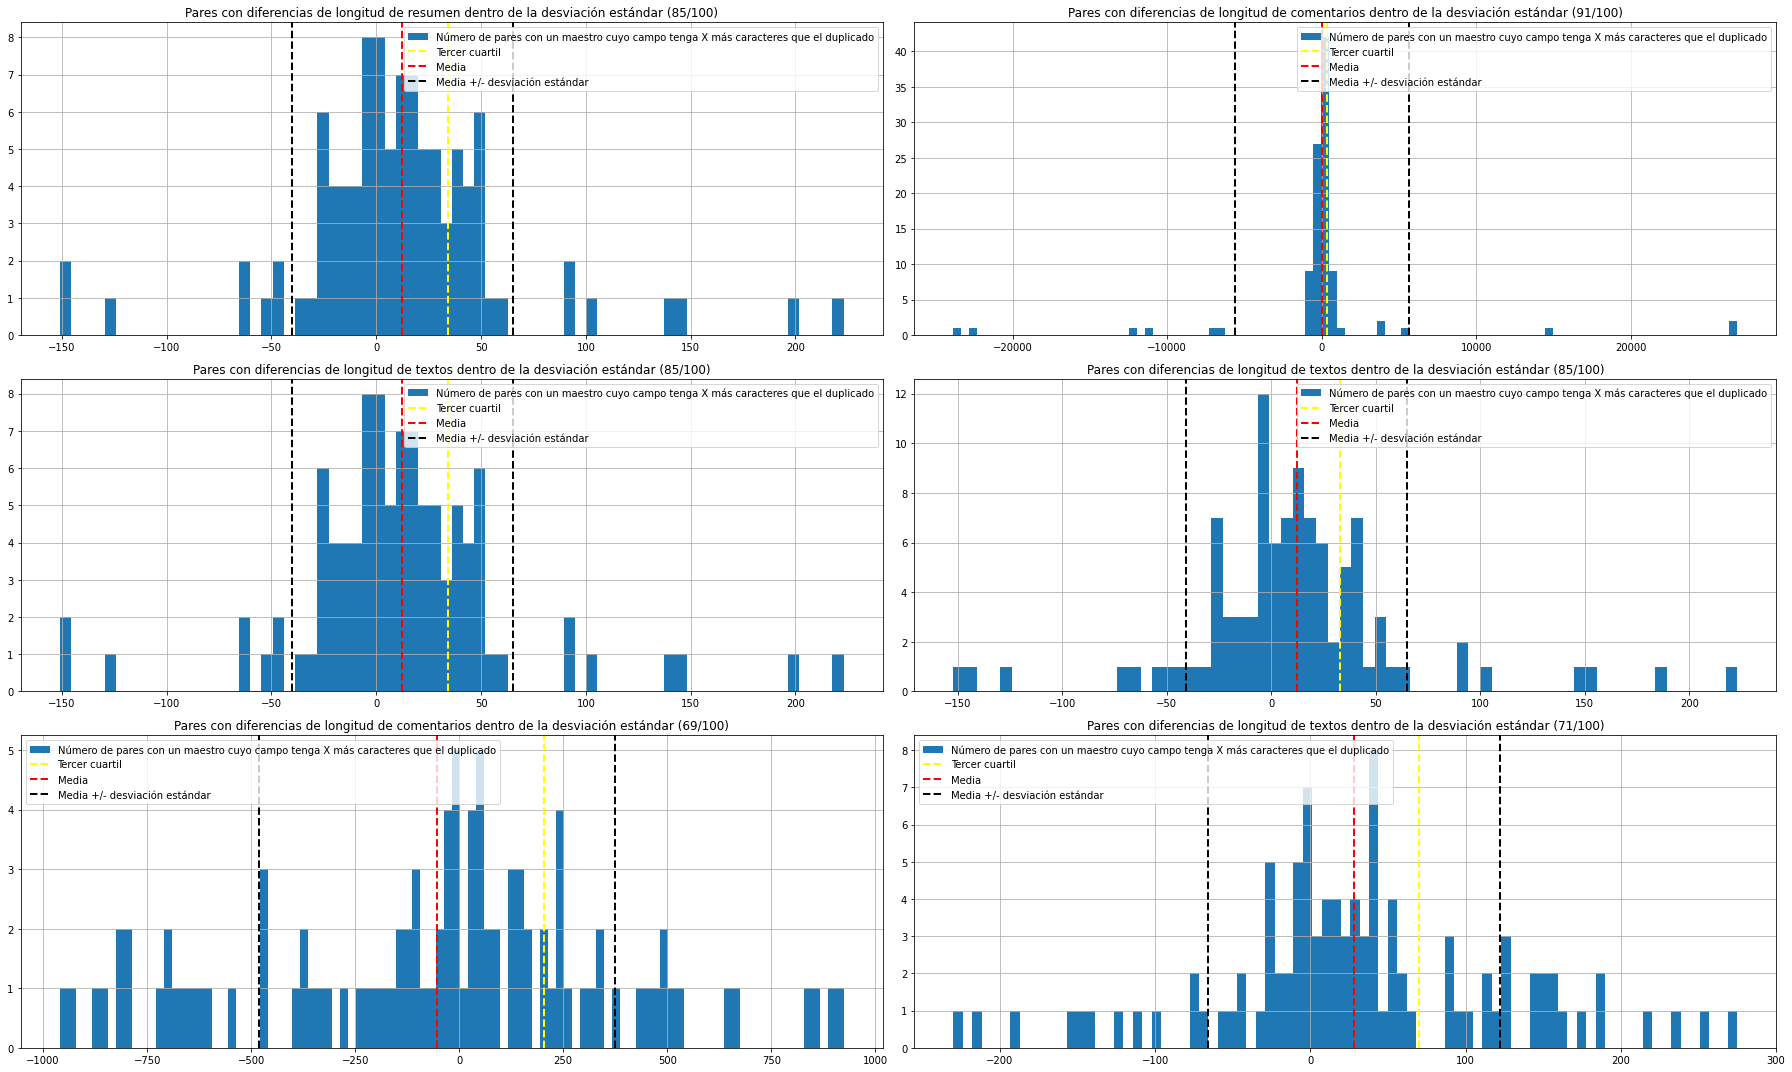

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(25, 15))


df_duplicate_pairs.hist(column='summary_len_diff', ax=axs[0,0], 
                        bins=len(df_duplicate_pairs.summary_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[0,0].axvline(x=np.percentile(df_duplicate_pairs.summary_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean() - df_duplicate_pairs.summary_len_diff.std(), 
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean() + df_duplicate_pairs.summary_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
summary_diff_inside_std_count = df_duplicate_pairs.summary_len_diff.between(
    df_duplicate_pairs.summary_len_diff.mean() - df_duplicate_pairs.summary_len_diff.std(),
    df_duplicate_pairs.summary_len_diff.mean() + df_duplicate_pairs.summary_len_diff.std()
).sum()
axs[0,0].set_title(f'Pares con diferencias de longitud de resumen dentro de la desviación estándar ({summary_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[0,0].legend()


df_duplicate_pairs.hist(column='comments_len_diff', ax=axs[0,1],
                        bins=len(df_duplicate_pairs.comments_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[0,1].axvline(x=np.percentile(df_duplicate_pairs.comments_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean() - df_duplicate_pairs.comments_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean() + df_duplicate_pairs.comments_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
comments_diff_inside_std_count = df_duplicate_pairs.comments_len_diff.between(
    df_duplicate_pairs.comments_len_diff.mean() - df_duplicate_pairs.comments_len_diff.std(),
    df_duplicate_pairs.comments_len_diff.mean() + df_duplicate_pairs.comments_len_diff.std()
).sum()
axs[0,1].set_title(f'Pares con diferencias de longitud de comentarios dentro de la desviación estándar ({comments_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[0,1].legend()


df_duplicate_pairs.hist(column='text1_len_diff', ax=axs[1,0],
                        bins=len(df_duplicate_pairs.text1_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[1,0].axvline(x=np.percentile(df_duplicate_pairs.text1_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean() - df_duplicate_pairs.text1_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean() + df_duplicate_pairs.text1_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text1_diff_inside_std_count = df_duplicate_pairs.text1_len_diff.between(
    df_duplicate_pairs.text1_len_diff.mean() - df_duplicate_pairs.text1_len_diff.std(),
    df_duplicate_pairs.text1_len_diff.mean() + df_duplicate_pairs.text1_len_diff.std()
).sum()
axs[1,0].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text1_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[1,0].legend()


df_duplicate_pairs.hist(column='text2_len_diff', ax=axs[1,1],
                        bins=len(df_duplicate_pairs.text2_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[1,1].axvline(x=np.percentile(df_duplicate_pairs.text2_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean() - df_duplicate_pairs.text2_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean() + df_duplicate_pairs.text2_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text2_diff_inside_std_count = df_duplicate_pairs.text2_len_diff.between(
    df_duplicate_pairs.text2_len_diff.mean() - df_duplicate_pairs.text2_len_diff.std(),
    df_duplicate_pairs.text2_len_diff.mean() + df_duplicate_pairs.text2_len_diff.std()
).sum()
axs[1,1].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text2_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[1,1].legend()


df_duplicate_pairs.hist(column='text3_len_diff', ax=axs[2,0],
                        bins=len(df_duplicate_pairs.text3_len_diff.unique()),    
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[2,0].axvline(x=np.percentile(df_duplicate_pairs.text3_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean() - df_duplicate_pairs.text3_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean() + df_duplicate_pairs.text3_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text3_diff_inside_std_count = df_duplicate_pairs.text3_len_diff.between(
    df_duplicate_pairs.text3_len_diff.mean() - df_duplicate_pairs.text3_len_diff.std(),
    df_duplicate_pairs.text3_len_diff.mean() + df_duplicate_pairs.text3_len_diff.std()
).sum()
axs[2,0].set_title(f'Pares con diferencias de longitud de comentarios dentro de la desviación estándar ({text3_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[2,0].legend()


df_duplicate_pairs.hist(column='text4_len_diff', ax=axs[2,1],
                        bins=len(df_duplicate_pairs.text4_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[2,1].axvline(x=np.percentile(df_duplicate_pairs.text4_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean() - df_duplicate_pairs.text4_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean() + df_duplicate_pairs.text4_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text4_diff_inside_std_count = df_duplicate_pairs.text4_len_diff.between(
    df_duplicate_pairs.text4_len_diff.mean() - df_duplicate_pairs.text4_len_diff.std(),
    df_duplicate_pairs.text4_len_diff.mean() + df_duplicate_pairs.text4_len_diff.std()
).sum()
axs[2,1].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text4_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[2,1].legend()


fig.tight_layout()
plt.show()

### Tokens comunes

In [69]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/ajburri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
df_reports['text1_tokens'] = [word_tokenize(s) for s in df_reports['text1']]
df_reports['text2_tokens'] = [word_tokenize(s) for s in df_reports['text2']]
df_reports['text3_tokens'] = [word_tokenize(s) for s in df_reports['text3']]
df_reports['text4_tokens'] = [word_tokenize(s) for s in df_reports['text4']]

unique_text1_tokens = set(word for tokens in df_reports['text1_tokens'] for word in tokens)
unique_text2_tokens = set(word for tokens in df_reports['text2_tokens'] for word in tokens)
unique_text3_tokens = set(word for tokens in df_reports['text3_tokens'] for word in tokens)
unique_text4_tokens = set(word for tokens in df_reports['text4_tokens'] for word in tokens)

print(f"Número de tokens únicos en Conjunto 1: {len(unique_text1_tokens)}")
print(f"Número de tokens únicos en Conjunto 2: {len(unique_text2_tokens)}")
print(f"Número de tokens únicos en Conjunto 3: {len(unique_text3_tokens)}")
print(f"Número de tokens únicos en Conjunto 4: {len(unique_text4_tokens)}")

Número de tokens únicos en Conjunto 1: 2874
Número de tokens únicos en Conjunto 2: 2942
Número de tokens únicos en Conjunto 3: 7718
Número de tokens únicos en Conjunto 4: 3534


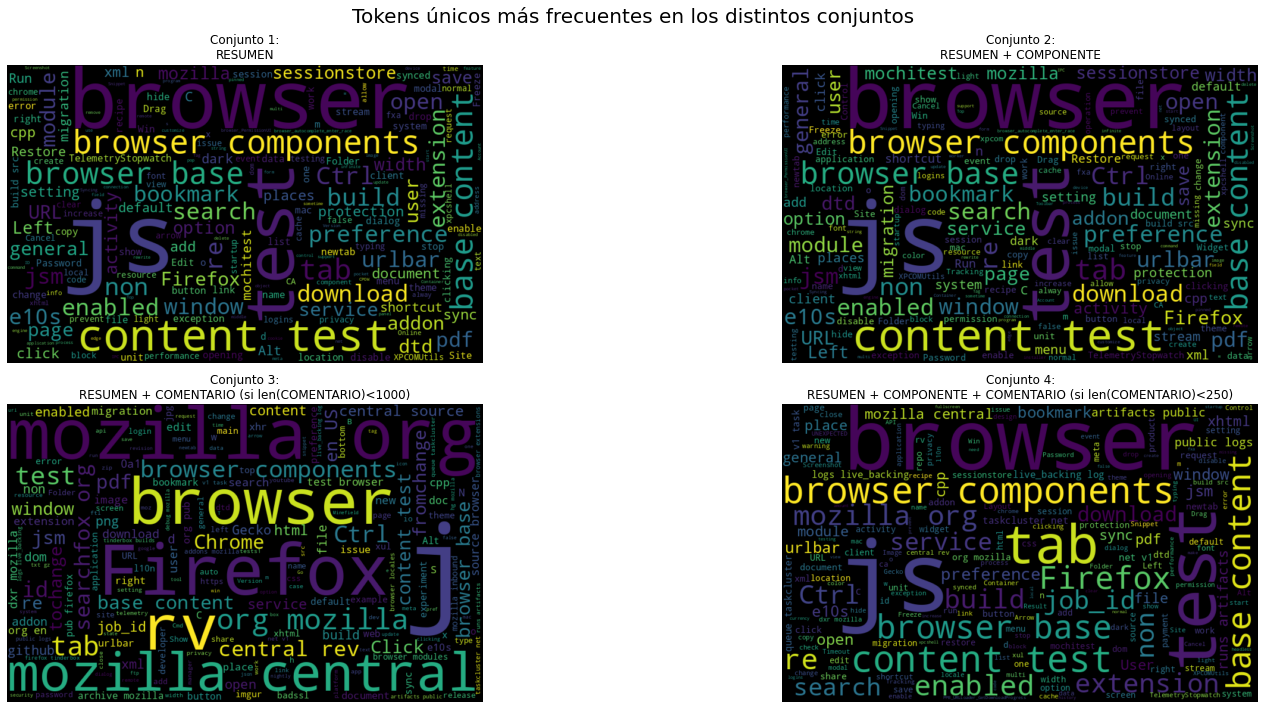

In [71]:
from wordcloud import WordCloud

text1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text1_tokens))
text2_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text2_tokens))
text3_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text3_tokens))
text4_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text4_tokens))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(text1_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(text2_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(text3_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(text4_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()

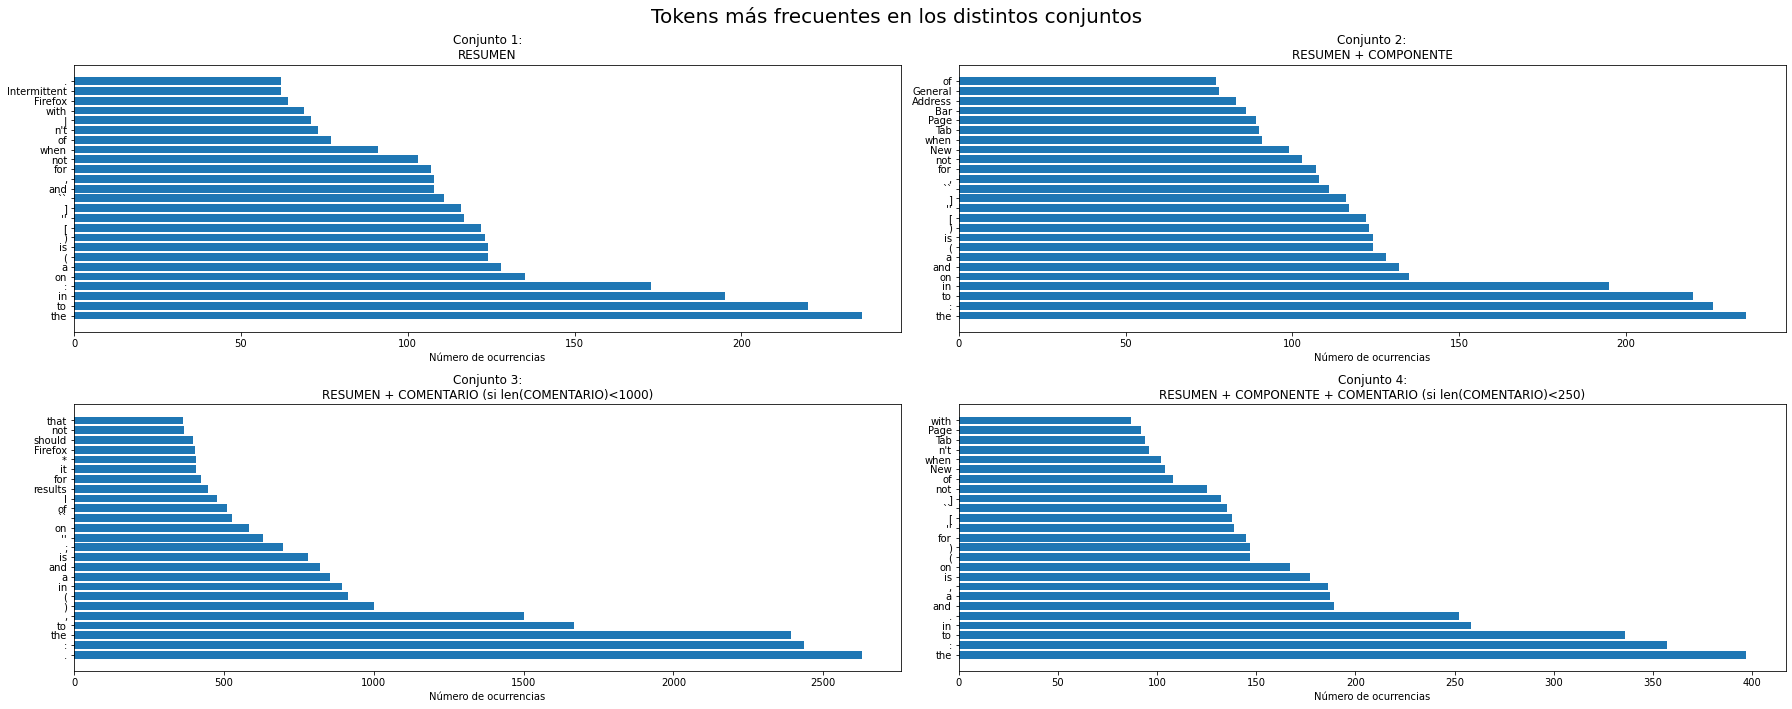

In [72]:
from collections import Counter

text1_counter = Counter(word for tokens in df_reports['text1_tokens'] for word in tokens)
text2_counter = Counter(word for tokens in df_reports['text2_tokens'] for word in tokens)
text3_counter = Counter(word for tokens in df_reports['text3_tokens'] for word in tokens)
text4_counter = Counter(word for tokens in df_reports['text4_tokens'] for word in tokens)

text1_counter_25 = text1_counter.most_common(25)
text2_counter_25 = text2_counter.most_common(25)
text3_counter_25 = text3_counter.most_common(25)
text4_counter_25 = text4_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(text1_counter_25)), [count for word, count in text1_counter_25], align='center')
axs[0, 0].set_yticks(range(len(text1_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in text1_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(text2_counter_25)), [count for word, count in text2_counter_25], align='center')
axs[0, 1].set_yticks(range(len(text2_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in text2_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(text3_counter_25)), [count for word, count in text3_counter_25], align='center')
axs[1, 0].set_yticks(range(len(text3_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in text3_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(text4_counter_25)), [count for word, count in text4_counter_25], align='center')
axs[1, 1].set_yticks(range(len(text4_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in text4_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()

### Tokens comunes por parejas

In [73]:
import warnings
warnings.filterwarnings('ignore')

df_duplicate_pairs['text1M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text1M']]
df_duplicate_pairs['text1D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text1D']]
df_duplicate_pairs['text2M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text2M']]
df_duplicate_pairs['text2D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text2D']]
df_duplicate_pairs['text3M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text3M']]
df_duplicate_pairs['text3D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text3D']]
df_duplicate_pairs['text4M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text4M']]
df_duplicate_pairs['text4D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text4D']]

df_duplicate_pairs['text1M_unique_tokens'] = df_duplicate_pairs['text1M_tokens'].apply(set)
df_duplicate_pairs['text1D_unique_tokens'] = df_duplicate_pairs['text1D_tokens'].apply(set)
df_duplicate_pairs['text2M_unique_tokens'] = df_duplicate_pairs['text2M_tokens'].apply(set)
df_duplicate_pairs['text2D_unique_tokens'] = df_duplicate_pairs['text2D_tokens'].apply(set)
df_duplicate_pairs['text3M_unique_tokens'] = df_duplicate_pairs['text3M_tokens'].apply(set)
df_duplicate_pairs['text3D_unique_tokens'] = df_duplicate_pairs['text3D_tokens'].apply(set)
df_duplicate_pairs['text4M_unique_tokens'] = df_duplicate_pairs['text4M_tokens'].apply(set)
df_duplicate_pairs['text4D_unique_tokens'] = df_duplicate_pairs['text4D_tokens'].apply(set)

df_duplicate_pairs['text1M_unique_tokens_len'] = df_duplicate_pairs['text1M_unique_tokens'].apply(len)
df_duplicate_pairs['text1D_unique_tokens_len'] = df_duplicate_pairs['text1D_unique_tokens'].apply(len)
df_duplicate_pairs['text2M_unique_tokens_len'] = df_duplicate_pairs['text2M_unique_tokens'].apply(len)
df_duplicate_pairs['text2D_unique_tokens_len'] = df_duplicate_pairs['text2D_unique_tokens'].apply(len)
df_duplicate_pairs['text3M_unique_tokens_len'] = df_duplicate_pairs['text3M_unique_tokens'].apply(len)
df_duplicate_pairs['text3D_unique_tokens_len'] = df_duplicate_pairs['text3D_unique_tokens'].apply(len)
df_duplicate_pairs['text4M_unique_tokens_len'] = df_duplicate_pairs['text4M_unique_tokens'].apply(len)
df_duplicate_pairs['text4D_unique_tokens_len'] = df_duplicate_pairs['text4D_unique_tokens'].apply(len)

df_duplicate_pairs['text1_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text1M_unique_tokens'] & row['text1D_unique_tokens'], axis=1)
df_duplicate_pairs['text2_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text2M_unique_tokens'] & row['text2D_unique_tokens'], axis=1)
df_duplicate_pairs['text3_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text3M_unique_tokens'] & row['text3D_unique_tokens'], axis=1)
df_duplicate_pairs['text4_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text4M_unique_tokens'] & row['text4D_unique_tokens'], axis=1)

df_duplicate_pairs['text1_common_tokens_len'] = df_duplicate_pairs['text1_common_tokens'].apply(len)
df_duplicate_pairs['text2_common_tokens_len'] = df_duplicate_pairs['text2_common_tokens'].apply(len)
df_duplicate_pairs['text3_common_tokens_len'] = df_duplicate_pairs['text3_common_tokens'].apply(len)
df_duplicate_pairs['text4_common_tokens_len'] = df_duplicate_pairs['text4_common_tokens'].apply(len)

In [74]:
df_duplicate_pairs[[
    'text1M_unique_tokens_len', 'text1D_unique_tokens_len', 'text2M_unique_tokens_len', 'text2D_unique_tokens_len',
    'text3M_unique_tokens_len', 'text3D_unique_tokens_len', 'text4M_unique_tokens_len', 'text4D_unique_tokens_len'
]].describe()

,text1M_unique_tokens_len,text1D_unique_tokens_len,text2M_unique_tokens_len,text2D_unique_tokens_len,text3M_unique_tokens_len,text3D_unique_tokens_len,text4M_unique_tokens_len,text4D_unique_tokens_len
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12.790000,10.360000,14.320000,11.830000,50.360000,54.370000,18.560000,14.520000
std,7.283987,5.248415,7.273697,5.380577,32.692791,30.332053,10.196375,8.135817
min,3.000000,2.000000,3.000000,3.000000,3.000000,6.000000,3.000000,3.000000
25%,7.750000,7.000000,9.000000,8.000000,25.000000,27.750000,10.000000,9.000000
50%,11.000000,9.000000,12.000000,11.000000,39.000000,51.000000,16.000000,12.000000
75%,16.000000,13.000000,18.000000,15.000000,80.250000,78.250000,24.750000,18.000000
max,39.000000,28.000000,41.000000,31.000000,123.000000,116.000000,50.000000,40.000000


In [75]:
df_duplicate_pairs[['text1_common_tokens_len', 'text2_common_tokens_len', 'text3_common_tokens_len', 'text4_common_tokens_len']].describe()

,text1_common_tokens_len,text2_common_tokens_len,text3_common_tokens_len,text4_common_tokens_len
count,100.000000,100.000000,100.000000,100.000000
mean,3.020000,3.940000,15.050000,4.340000
std,3.832292,3.850279,13.228661,4.200096
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,5.000000,2.000000
50%,2.000000,3.000000,11.000000,3.500000
75%,4.000000,5.000000,22.000000,5.000000
max,25.000000,25.000000,78.000000,25.000000


In [76]:
rank = {}
for i,row in df_duplicate_pairs.iterrows():
    for t in row['text1_common_tokens']:
        if t in rank:
            rank[t] += 1
        else:
            rank[t] = 1
rank = sorted(rank.items(), key=lambda x: x[1], reverse=True)

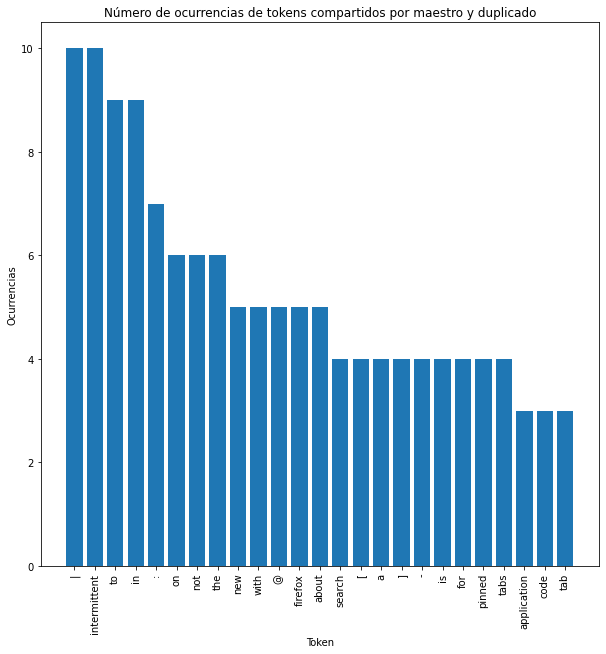

In [77]:
TOP_TOKENS = 25
plt.figure(figsize=(10,10))
plt.bar(range(len(rank[:TOP_TOKENS])), [x[1] for x in rank[:TOP_TOKENS]], align='center')
plt.xticks(range(len(rank[:TOP_TOKENS])), [x[0] for x in rank[:TOP_TOKENS]], rotation=90)
plt.xlabel('Token')
plt.ylabel('Ocurrencias')
plt.title('Número de ocurrencias de tokens compartidos por maestro y duplicado')
plt.show()


# Persistir los reportes y pares de reportes

In [78]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_reports[[
    'report_id', 'creation_time', 'status', 'component', 'dupe_of', 'summary', 'comments',
    'text1', 'text2', 'text3', 'text4'
]].to_pickle('data/raw_reports.pkl')

df_report_pairs[[
    'type', 'id_M', 'id_D', 'statusM', 'statusD', 'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM', 'commentsD',
    'text1M', 'text1D', 'text2M', 'text2D', 'text3M', 'text3D', 'text4M', 'text4D'
]].to_pickle('data/raw_report_pairs.pkl')